In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
import numpy as np 
import pickle
from sklearn.metrics import classification_report
from sklearn import metrics
from keras.models import Sequential, Model,load_model
import matplotlib.pyplot as plt 
from sklearn.metrics import roc_curve, auc, roc_auc_score,f1_score,recall_score,precision_score,accuracy_score,confusion_matrix,ConfusionMatrixDisplay,classification_report
from sklearn.preprocessing import label_binarize,LabelEncoder
from keras.callbacks import EarlyStopping,ModelCheckpoint
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder,StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [2]:
df=pd.read_csv('../input/crops/fertilizer.csv')
df.head()

,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name
0,26,52,38,Sandy,Maize,37,0,0,Urea
1,29,52,45,Loamy,Sugarcane,12,0,36,DAP
2,34,65,62,Black,Cotton,7,9,30,14-35-14
3,32,62,34,Red,Tobacco,22,0,20,28-28
4,28,54,46,Clayey,Paddy,35,0,0,Urea


In [3]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Temparature,205.0,30.204878,3.592882,25.0,27.0,30.0,33.0,38.0
Humidity,205.0,58.990244,5.973791,50.0,54.0,60.0,64.0,72.0
Moisture,205.0,43.590244,11.236665,25.0,34.0,42.0,51.0,65.0
Nitrogen,205.0,18.814634,11.273115,4.0,10.0,14.0,24.0,42.0
Potassium,205.0,3.219512,5.571778,0.0,0.0,0.0,7.0,19.0
Phosphorous,205.0,18.634146,13.494654,0.0,9.0,18.0,30.0,42.0


In [4]:
df.shape

(205, 9)

In [5]:
df['Fertilizer Name'].value_counts()

Fertilizer Name
Urea        44
DAP         38
28-28       36
20-20       30
14-35-14    29
17-17-17    18
10-26-26    10
Name: count, dtype: int64

In [6]:
df.isnull().sum()

Temparature        0
Humidity           0
Moisture           0
Soil Type          0
Crop Type          0
Nitrogen           0
Potassium          0
Phosphorous        0
Fertilizer Name    0
dtype: int64

In [7]:
df.nunique()

Temparature        14
Humidity           13
Moisture           41
Soil Type           5
Crop Type          11
Nitrogen           24
Potassium          13
Phosphorous        32
Fertilizer Name     7
dtype: int64

In [8]:
df.dtypes[df.dtypes =='object']

Soil Type          object
Crop Type          object
Fertilizer Name    object
dtype: object

In [9]:
df.corr()

ValueError: could not convert string to float: 'Sandy'

In [10]:
class_names = df['Fertilizer Name'].unique()
print(class_names)

['Urea' 'DAP' '14-35-14' '28-28' '17-17-17' '20-20' '10-26-26']


In [11]:
LE= LabelEncoder()
df['Soil Type'] = LE.fit_transform(df['Soil Type'])
Soil_Type = pd.DataFrame(zip(LE.classes_,LE.transform(LE.classes_)),columns=['Original','Encoded'])
Soil_Type = Soil_Type.set_index('Original')
Soil_Type

,Encoded
Original,
Black,0
Clayey,1
Loamy,2
Red,3
Sandy,4


In [13]:
LE1 =  LabelEncoder()
df['Crop Type'] = LE1.fit_transform(df['Crop Type'])
Crop_Type = pd.DataFrame(zip(LE1.classes_,LE1.transform(LE1.classes_)),columns=['Original','Encoded'])
Crop_Type = Crop_Type.set_index('Original')
Crop_Type

,Encoded
Original,
0,0
1,1
2,2
3,3
4,4
5,5
6,6
7,7
8,8


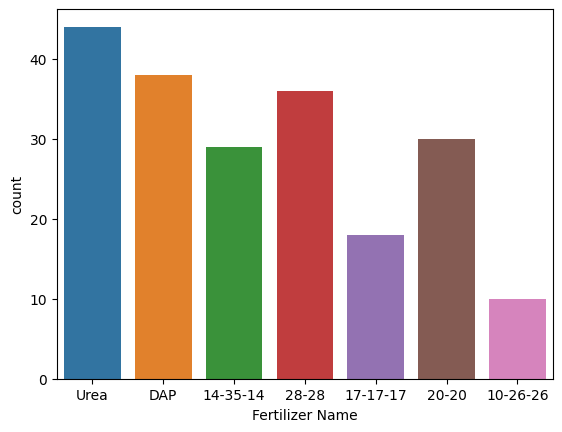

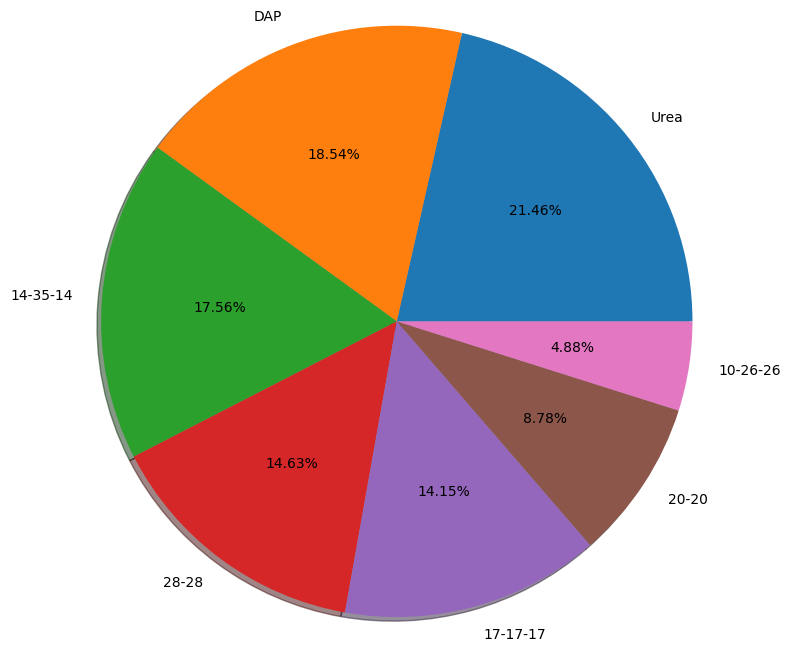

In [14]:
sns.countplot(x='Fertilizer Name', data=df)
labels= 'Urea', 'DAP', '14-35-14', '28-28', '17-17-17', '20-20','10-26-26'
fig,ax=plt.subplots()
ax.pie(df['Fertilizer Name'].value_counts(),labels=labels,radius=2,autopct='%1.2f%%', shadow=True)
plt.show()

In [15]:
df.head()

,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name
0,26,52,38,4,3,37,0,0,Urea
1,29,52,45,2,8,12,0,36,DAP
2,34,65,62,0,1,7,9,30,14-35-14
3,32,62,34,3,9,22,0,20,28-28
4,28,54,46,1,6,35,0,0,Urea


In [16]:
label_encoder =LabelEncoder()
df['Fertilizer Name']= label_encoder.fit_transform(df['Fertilizer Name'])
target_names = label_encoder.classes_
target_names

array(['10-26-26', '14-35-14', '17-17-17', '20-20', '28-28', 'DAP',
       'Urea'], dtype=object)

In [17]:
X=df.drop('Fertilizer Name',axis=1)
Y=df['Fertilizer Name']

In [18]:
from imblearn.over_sampling import SMOTE
from collections import Counter

smote = SMOTE(sampling_strategy={0: 100, 1: 100, 2: 100, 3: 100, 4: 100, 5: 100, 6: 100})
X, Y = smote.fit_resample(X, Y)

print(X.shape)

print(Counter(Y))

(700, 8)
Counter({6: 100, 5: 100, 1: 100, 4: 100, 2: 100, 3: 100, 0: 100})


In [19]:
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.2)

In [20]:
acc = []
models = []
x_train.shape

(560, 8)

In [21]:
def evaluate_model(model,X_test , y_test):
    results = model.evaluate(X_test, y_test)
    return results

def Accuracy(y_test , y_pred):
    AccScore = accuracy_score(y_test, y_pred, normalize=True)
    return AccScore

def macro_precision(y_test , y_pred):
    PrecisionScore = precision_score(y_test, y_pred, average='macro') 
    return PrecisionScore
 
def macro_recall(y_test , y_pred):
    RecallScore = recall_score(y_test, y_pred, average='macro') 
    return  RecallScore

def macro_F1Score(y_test , y_pred):
    F1Score = f1_score(y_test, y_pred, average='macro') 
    return F1Score

def AUC(actual_class, pred_class, average = "micro"):
    unique_class = set(actual_class)
    roc_auc_dict = {}
    for per_class in unique_class:
        other_class = [x for x in unique_class if x != per_class]
        new_actual_class = [0 if x in other_class else 1 for x in actual_class]
        new_pred_class = [0 if x in other_class else 1 for x in pred_class]
        roc_auc = roc_auc_score(new_actual_class, new_pred_class, average = average)
        roc_auc_dict[per_class] = roc_auc
    return roc_auc_dict

In [22]:
class_names_dict = {index: class_name for index, class_name in enumerate(class_names)}

In [23]:
sc = StandardScaler()
x_train_n = sc.fit_transform(x_train, y_train)
x_test_n = sc.transform(x_test)

In [52]:
num_classes=7
model = Sequential()
model.add(Dense(7, activation='relu', input_shape=(x_train.shape[1],)))
model.add(Dense(3, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_23 (Dense)            (None, 7)                 63        
                                                                 
 dense_24 (Dense)            (None, 3)                 24        
                                                                 
 dense_25 (Dense)            (None, 7)                 28        
                                                                 
Total params: 115 (460.00 Byte)
Trainable params: 115 (460.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [53]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [54]:
model_name = "weight.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.00000001)
model.fit(x_train_n, y_train,epochs=100, validation_split=.2,callbacks =[checkpoint,earlystopping,learning_rate_reduction])

Epoch 1/100
 1/14 [=>............................] - ETA: 10s - loss: 1.9551 - accuracy: 0.0000e+00
Epoch 1: val_loss improved from inf to 1.90165, saving model to weight.h5
14/14 [==============================] - 1s 23ms/step - loss: 1.8992 - accuracy: 0.1317 - val_loss: 1.9017 - val_accuracy: 0.1250 - lr: 0.0010
Epoch 2/100
 1/14 [=>............................] - ETA: 0s - loss: 1.8615 - accuracy: 0.2500
Epoch 2: val_loss improved from 1.90165 to 1.89114, saving model to weight.h5
14/14 [==============================] - 0s 7ms/step - loss: 1.8869 - accuracy: 0.1652 - val_loss: 1.8911 - val_accuracy: 0.1964 - lr: 0.0010
Epoch 3/100
 1/14 [=>............................] - ETA: 0s - loss: 1.8590 - accuracy: 0.2188
Epoch 3: val_loss improved from 1.89114 to 1.87950, saving model to weight.h5
14/14 [==============================] - 0s 8ms/step - loss: 1.8768 - accuracy: 0.2054 - val_loss: 1.8795 - val_accuracy: 0.2232 - lr: 0.0010
Epoch 4/100
 1/14 [=>............................] - 

In [55]:
loss, accuracy = model.evaluate(x_test_n, y_test)
print('Test loss:', loss)
print('Test accuracy:', accuracy)
acc.append(accuracy)
models.append('Neural Network')

5/5 [==============================] - 0s 3ms/step - loss: 0.2903 - accuracy: 0.9786
Test loss: 0.29030752182006836
Test accuracy: 0.9785714149475098


In [56]:
predicted_NN = model.predict(x_test_n)
predicted_NN = np.argmax(predicted_NN, axis=1)
print(classification_report(y_test, predicted_NN, target_names=target_names))

5/5 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

    10-26-26       0.95      0.95      0.95        21
    14-35-14       1.00      0.94      0.97        17
    17-17-17       0.96      1.00      0.98        23
       20-20       0.94      1.00      0.97        17
       28-28       1.00      0.96      0.98        26
         DAP       1.00      1.00      1.00        23
        Urea       1.00      1.00      1.00        13

    accuracy                           0.98       140
   macro avg       0.98      0.98      0.98       140
weighted avg       0.98      0.98      0.98       140



In [57]:
print("***** Neural Network Evaluations Details ******** \n")
print("Test loss, Test accuray : " , evaluate_model(model,x_test_n , y_test)) 
print("------------------------------------------------")
print("Accuray  : " , Accuracy(y_test , predicted_NN)) 
print("------------------------------------------------")
print("Precision Score is : " , macro_precision(y_test , predicted_NN))
print("------------------------------------------------")
print("Recall Scores is : " , macro_recall(y_test , predicted_NN))
print("------------------------------------------------")
print('F1 Score is : ', macro_F1Score(y_test , predicted_NN))
print("------------------------------------------------")
auc_scores = AUC(y_test, predicted_NN)
auc_scores_with_names = {class_names_dict[label]: auc for label, auc in auc_scores.items()}
print('AUC Score is : ' ,auc_scores_with_names)

***** Neural Network Evaluations Details ******** 

5/5 [==============================] - 0s 4ms/step - loss: 0.2903 - accuracy: 0.9786
Test loss, Test accuray :  [0.29030752182006836, 0.9785714149475098]
------------------------------------------------
Accuray  :  0.9785714285714285
------------------------------------------------
Precision Score is :  0.9793083900226758
------------------------------------------------
Recall Scores is :  0.9792994120725212
------------------------------------------------
F1 Score is :  0.9789460078035083
------------------------------------------------
AUC Score is :  {'Urea': 0.9719887955182073, 'DAP': 0.9705882352941176, '14-35-14': 0.9957264957264957, '28-28': 0.9959349593495934, '17-17-17': 0.9807692307692308, '20-20': 1.0, '10-26-26': 1.0}
